# Import packages and defining helper function

In [1]:
import sys
sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange, reduce
from tqdm import tqdm, trange
from torch.nn import functional as F
from utils.download_mnist import mnist_dataloader_test
from assembler import get_config, get_config_ebm, make_energy_model
from utils.config import show 

path = !cd .. && pwd
path = path[0]

def plotable(img):
    return rearrange(img, "b c h w -> (b c h) w ").cpu().detach().numpy()

def get_model_config(model_name):
    dataset, model, sampling, task = model_name.split("/")
    name = f"{sampling}/{task}"
    config = get_config(get_config_ebm, dataset, model, name, path=path)
    return config

def pixelwise_varaince(imgs):
    ex = reduce(imgs, "b h w -> h w", "mean")
    ex2 = reduce(imgs**2, "b h w -> h w", "mean")
    return ex2 - ex**2

def reconstruction_error(x_hat, x, reduction="mean"):
    return F.mse_loss(x_hat, x, reduction=reduction)

In [2]:
model_name = "mnist/vae/langevin/inpainting"
config = get_model_config(model_name)
dm = mnist_dataloader_test(config, path=path)

/home/mingliang/anaconda3/envs/dgflowenv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Defining Experimental Params

In [3]:
show(config)

operator_params
    operator: CenterOcclude
    size: 13
estimator_params
    estimator: langevin
    burn_in: 0
    n_samples: 15
    step_size: 0.01
    mode: avg
    initalisation: posterior
    potential: mse
base_model_params
    model_name: mnist/vae/vanilla


# The experiment 

## Initalisation used

In [4]:
config["operator_params"]["operator"] = "RandomOcclude"
config["operator_params"]["num_measurements"] = 200

## Baseline of 0

In [5]:
error = []
for x, y in dm:
    x = x.to("cuda")
    error.append(reconstruction_error(torch.zeros_like(x), x))
baseline = (sum(error)/len(error)).cpu().detach()

## Repeat for different measurments

In [7]:
config["exp_params"]["batch_size"] = 1
dm = mnist_dataloader_test(config, path=path)

In [8]:
ebm = make_energy_model(config, path=path)
emb = ebm.to("cuda")

In [9]:
ebm.operator.A = ebm.operator.A.to("cuda")

In [10]:
gen = iter(dm)
x, y = next(gen)
x = x.to("cuda")

In [11]:
imgs = torch.zeros(100, 32, 32)
x_tilde = ebm.operator(x)
for num in trange(0, 100):
    x_hat = rearrange(ebm(x_tilde), "b c h w -> (b c) h w")
    imgs[num, : , :] = x_hat

100%|██████████| 100/100 [00:03<00:00, 25.56it/s]


In [12]:
var = pixelwise_varaince(imgs).detach().numpy()

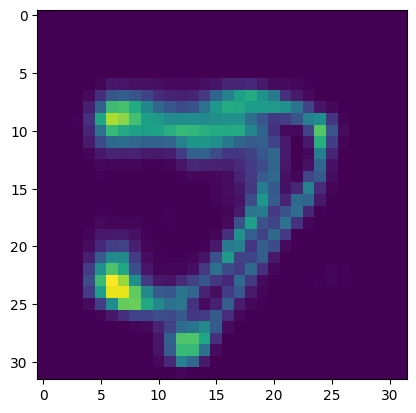

In [13]:
plt.imshow(var)
plt.show()

In [14]:
x, y = next(gen)
x = x.to("cuda")

In [15]:
imgs = torch.zeros(50, 32, 32)
for num in trange(0, 50):
    x_tilde = ebm.operator(x)
    x_hat = ebm(x_tilde)
    imgs[num, : , :] = x_hat

100%|██████████| 50/50 [00:01<00:00, 29.53it/s]


In [16]:
var = pixelwise_varaince(imgs).detach().numpy()

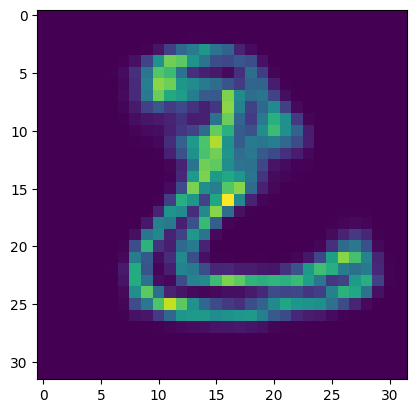

In [17]:
plt.imshow(var)
plt.show()

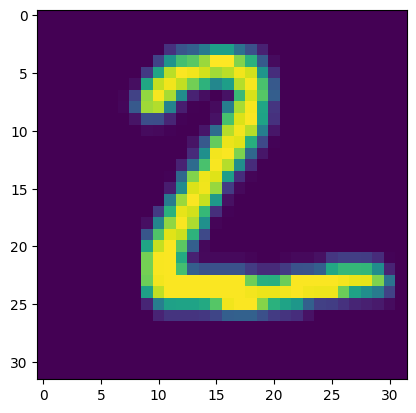

In [20]:
plt.imshow(rearrange(x.cpu(), "b c h w -> (b c h) w"))
plt.show()

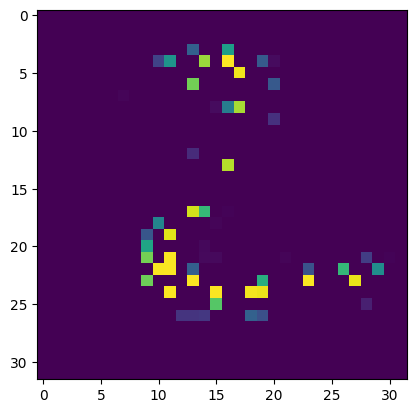

In [19]:
plt.imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
plt.show()